# Week 5 — Track C: Evaluation & Guardrails (Fixed Template)

This notebook is a cleaned-up, ready-to-run scaffold that implements:
- Corpus ingestion (PDF → chunks) with overlap
- Hybrid retrieval with **BM25 + Dense** and **RRF fusion**
- Optional **cross-encoder reranker** (bge-reranker) with graceful fallback
- Guardrails: **citation enforcement**, **PII redaction**, **safe refusals**
- An **evaluation loop** reading a JSONL eval set
- **Before vs After** results + CSVs + environment/config logs

Fill in the `pdfs` dictionary and (optionally) the eval JSONL path to match your project.


In [ ]:
#@title 0) Setup: installs (Colab-friendly) & imports
import sys, os, json, time, re, platform, pkg_resources
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import List, Dict, Tuple

try:
    from langchain_community.document_loaders import PyPDFLoader
    from langchain_text_splitters import RecursiveCharacterTextSplitter
    from langchain_community.retrievers import BM25Retriever
    from langchain_community.vectorstores import Chroma
    from langchain_community.embeddings import HuggingFaceEmbeddings
except Exception:
    %pip -q install langchain-community langchain-text-splitters chromadb sentence-transformers pypdf
    from langchain_community.document_loaders import PyPDFLoader
    from langchain_text_splitters import RecursiveCharacterTextSplitter
    from langchain_community.retrievers import BM25Retriever
    from langchain_community.vectorstores import Chroma
    from langchain_community.embeddings import HuggingFaceEmbeddings


!pip install -q langchain langchain-community

!pip install -q rank_bm25

!pip install -q transformers accelerate sentencepiece

!pip install -q langchain-huggingface



# Optional: mount Google Drive if you're on Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

plt.rcParams['figure.figsize'] = (6,4)
print('Setup complete')




/tmp/ipython-input-3578368565.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, os, json, time, re, platform, pkg_resources


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.4 MB/s eta 0:0

In [ ]:
#@title 0.5) Metrics


def correctness_metric(answer: str, gold: str) -> float:
    # bi-gram overlap proxy (simplified correctness)
    gold_tokens = gold.lower().split()
    ans_tokens = answer.lower().split()
    overlap = sum(1 for t in ans_tokens if t in gold_tokens)
    return overlap / max(1, len(gold_tokens))

def faithfulness_metric(answer: str, gold: str) -> float:
    # proxy: if citations exist, mark faithful
    return 1.0 if "[" in answer and "]" in answer else 0.0




In [ ]:
#@title 1) Load & chunk PDFs → corpus DataFrame
PDF_BASE_PATH = "/content/drive/My Drive/Capstone/Academic Papers"  #@param {type:"string"}
pdfs = {
    "Maia-2 Paper": "Maia-2 Paper.pdf",
    "Chess GPT Paper": "Chess GPT Paper.pdf",
    "Chess Bench with Stockfish Paper": "Chess Bench with Stockfish Paper.pdf"
} #@param {type:"raw"}

CHUNK_SIZE = 300  #@param {type:"integer"}
CHUNK_OVERLAP = 50  #@param {type:"integer"}

docs = []
splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
for doc_id, fname in pdfs.items():
    path = os.path.join(PDF_BASE_PATH, fname)
    if not os.path.exists(path):
        print(f"Missing PDF: {path}")
        continue
    loader = PyPDFLoader(path)
    pages = loader.load_and_split()
    chunks = splitter.split_documents(pages)
    for i, ch in enumerate(chunks):
        docs.append({
            "doc_id": doc_id,
            "chunk_id": f"{doc_id}_chunk{i+1}",
            "text": ch.page_content
        })

corpus = pd.DataFrame(docs)
print('Corpus:', corpus.shape)
display(corpus.head(3))
print('Unique doc_ids:', corpus.doc_id.unique())


Corpus: (1278, 3)


,doc_id,chunk_id,text
0,Maia-2 Paper,Maia-2 Paper_chunk1,Maia-2: A Unified Model for Human-AI Alignment...
1,Maia-2 Paper,Maia-2 Paper_chunk2,Cornell University\nkleinberg@cornell.edu\nSid...
2,Maia-2 Paper,Maia-2 Paper_chunk3,systems both surpass human ability and accurat...


Unique doc_ids: ['Maia-2 Paper' 'Chess GPT Paper' 'Chess Bench with Stockfish Paper']


In [ ]:
#@title 2) Build hybrid retriever: BM25 + Dense + RRF fusion
PERSIST_DIR = "/content/drive/My Drive/Capstone"  #@param {type:"string"}
K_BM25 = 10  #@param {type:"integer"}
K_DENSE = 10  #@param {type:"integer"}
TOP_K = 8  #@param {type:"integer"} # final top-k after fusion

assert len(corpus) > 0, "Corpus is empty; load PDFs first."

# BM25 over raw texts (keeps our metadata alongside)
bm25 = BM25Retriever.from_texts(
    texts=corpus["text"].tolist(),
    metadatas=corpus[["doc_id","chunk_id"]].to_dict(orient="records"),
)
bm25.k = K_BM25

# Dense retriever via Chroma + sentence-transformers
emb = HuggingFaceEmbeddings(model_name='intfloat/e5-large')
vectordb = Chroma(
    collection_name="trackc_e5large",
    embedding_function=emb,
    persist_directory=PERSIST_DIR,
)
if vectordb._collection.count() == 0:
    print('Indexing into Chroma…')
    vectordb = Chroma.from_texts(
        texts=corpus["text"].tolist(),
        embedding=emb,
        metadatas=corpus[["doc_id","chunk_id"]].to_dict(orient="records"),
        persist_directory=PERSIST_DIR,
        collection_name="trackc_e5large",
    )
dense_retriever = vectordb.as_retriever(search_kwargs={"k": K_DENSE})

def rrf_fuse(bm25_results, dense_results, k=TOP_K, c=60):
    # Reciprocal Rank Fusion over two ranked lists
    scores = {}
    def add_scores(results, offset=0):
        for rank, d in enumerate(results, start=1):
            key = (d.metadata.get('doc_id'), d.metadata.get('chunk_id'))
            scores[key] = scores.get(key, 0.0) + 1.0 / (c + rank)
    add_scores(bm25_results)
    add_scores(dense_results)
    # recover objects by matching keys
    key2doc = {}
    for d in bm25_results + dense_results:
        key = (d.metadata.get('doc_id'), d.metadata.get('chunk_id'))
        key2doc[key] = d
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]
    return [key2doc[k] for k,_ in ranked]

def hybrid_retrieve(query: str, top_k=TOP_K):
    b = bm25.get_relevant_documents(query)
    d = dense_retriever.get_relevant_documents(query)
    fused = rrf_fuse(b, d, k=top_k)
    return fused

print('Hybrid retriever ready')


/tmp/ipython-input-1012464355.py:17: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  emb = HuggingFaceEmbeddings(model_name='intfloat/e5-large')
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

/tmp/ipython-input-1012464355.py:18: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(


Hybrid retriever ready


In [ ]:
#@title 3) Optional reranker (CrossEncoder). Falls back to identity if unavailable.
USE_RERANKER = True  #@param {type:"boolean"}
RERANKER_MODEL = "BAAI/bge-reranker-base"  #@param {type:"string"}
reranker = None
if USE_RERANKER:
    try:
        from sentence_transformers import CrossEncoder
        reranker = CrossEncoder(RERANKER_MODEL)
        print('Reranker loaded')
    except Exception as e:
        print('Could not load reranker, falling back to no-rerank:', e)
        reranker = None

def apply_rerank(query: str, docs: List):
    if not reranker:
        return docs
    pairs = [[query, d.page_content] for d in docs]
    scores = reranker.predict(pairs)
    order = np.argsort(-np.array(scores))
    return [docs[i] for i in order]


config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Reranker loaded


In [ ]:
# @title 3.5) HuggingFace LLM with RetrievalQA (TinyLlama)

from langchain.chains import RetrievalQA
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from typing import List

from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# --- Model setup ---
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",      # let accelerate place on GPU/CPU
    torch_dtype="auto"      # saves VRAM on GPU
)

# text-generation pipeline (no `device` here, since we used device_map)
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.2
)

# Wrap into LangChain
llm = HuggingFacePipeline(pipeline=generator)
print("TinyLlama LLM initialized")

# --- Hybrid Retriever wrapper ---
class HybridRetriever(BaseRetriever):
    def _get_relevant_documents(self, query: str) -> List[Document]:
        return hybrid_retrieve(query)

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        return self._get_relevant_documents(query)

retriever = HybridRetriever()

# --- RetrievalQA chain ---
qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    return_source_documents=True
)

print("TinyLlama LLM connected to retriever")





tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


TinyLlama LLM initialized
TinyLlama LLM connected to retriever


In [ ]:
#@title 4) Eval set (JSONL) — create if missing (replace with your real queries!)
EVAL_JSONL = "/content/drive/My Drive/Capstone/Week5_EvalSet_TrackC.jsonl"  #@param {type:"string"}
if not os.path.exists(EVAL_JSONL):
    demo_rows = [
        {"qid":"q1","query":"What is the main contribution of Maia-2?","gold_answer":"Maia-2 predicts human chess moves with high accuracy.","gold_source_ids":["Maia2_Paper"]},
        {"qid":"q2","query":"What does ChessBench evaluate?","gold_answer":"ChessBench compares LLMs to Stockfish on chess tasks.","gold_source_ids":["ChessBench_Paper"]},
        {"qid":"q3","query":"How does ChessGPT differ from Maia-2?","gold_answer":"ChessGPT generates commentary; Maia-2 predicts human moves.","gold_source_ids":["ChessGPT_Paper","Maia2_Paper"]},
        {"qid":"q4","query":"What limitation is noted in the Chess GPT paper?","gold_answer":"Limited performance on complex tactical positions.","gold_source_ids":["ChessGPT_Paper"]},
        {"qid":"q5","query":"Name a dataset or benchmark used in these papers.","gold_answer":"ChessBench is a benchmark used to compare systems.","gold_source_ids":["ChessBench_Paper"]},
    ]
    with open(EVAL_JSONL,'w') as f:
        for row in demo_rows:
            f.write(json.dumps(row)+"\n")
    print('Created demo eval set — please replace with 10–20 real project queries.')

def load_jsonl(path):
    return [json.loads(line) for line in open(path) if line.strip()]

eval_rows = load_jsonl(EVAL_JSONL)
print('Eval rows:', len(eval_rows))
pd.DataFrame(eval_rows).head()


Eval rows: 18


,qid,query,gold_answer,gold_source_ids
0,q1,What reduction in perplexity did Maia-2 achiev...,Maia-2’s gains in perplexity are similarly str...,[Maia-2 Paper]
1,q2,How many positions did Maia-2 treat monotonica...,"In the Grounded Testset of 100K positions, we ...",[Maia-2 Paper]
2,q3,How does Maia-2 compare to Maia-1 in terms of ...,Maia-2 demonstrates strong and consistent perf...,[Maia-2 Paper]
3,q4,What percentage of positions did Maia-2 treat ...,Maia-2 treats substantially more positions tra...,[Maia-2 Paper]
4,q5,What effect does changing one’s own skill have...,Changing one’s own skill against a fixed oppon...,[Maia-2 Paper]


In [ ]:
#@title 5) Guardrails: citation enforcement, PII redaction, safety
PII_PATTERNS = [
    (re.compile(r"\b\d{3}[-.\s]?\d{2}[-.\s]?\d{4}\b"), "[REDACTED-SSN]"),
    (re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}"), "[REDACTED-EMAIL]"),
    (re.compile(r"\b\+?\d{1,3}[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}\b"), "[REDACTED-PHONE]")
]


UNSAFE_TRIGGERS = [
    re.compile(r"(give me|list).*password|ssn|social security|phone number|email", re.I),
]


def redact_pii(text: str) -> str:
    out = text
    for pat, repl in PII_PATTERNS:
        out = pat.sub(repl, out)
    return out


def is_unsafe(query: str) -> bool:
    return any(p.search(query or "") for p in UNSAFE_TRIGGERS)


def enforce_citations(answer: str, retrieved_doc_ids: List[str]) -> str:
    has_cite = any(doc_id in (answer or "") for doc_id in retrieved_doc_ids)
    if not has_cite:
        return "Sorry, I cannot answer with sufficient evidence."
    return answer

print('Guardrails ready')



Guardrails ready


In [ ]:
#@title 5.5) Retrieval QA with answering function

from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,               # already defined earlier
    retriever=retriever,   # already defined earlier
    chain_type="stuff",
)

def answer_question(query: str, use_guardrails=False) -> str:
    try:
        answer = qa_chain.run(query)
    except Exception as e:
        return f"Error during answering: {e}"

    if use_guardrails:
        if is_unsafe(query) or is_unsafe(answer):
            return "Refusal: This is unsafe and cannot be answered."
        answer = redact_pii(answer)
        answer = enforce_citations(answer, ["doc1", "doc2"])

    return answer


In [ ]:
#@title 6) Retrieval helper + (stub) answerer with inline citations
def retrieve_with_rerank(query: str, top_k=TOP_K):
    docs = hybrid_retrieve(query, top_k=top_k)
    docs = apply_rerank(query, docs)
    return docs


def simple_answer_from_context(query: str, docs: List, max_chars=450) -> str:
    # Stub: concatenates top snippets and appends citations [doc_id]
    # Replace with your LLM call if desired.
    context = []
    cited = []
    for d in docs[:3]:
        di = d.metadata.get('doc_id')
        snippet = d.page_content.strip().replace('\n',' ')
        context.append(snippet)
        if di not in cited:
            cited.append(di)
    text = (" ".join(context))[:max_chars]
    cites = " ".join(f"[{cid}]" for cid in cited)
    return f"{text} {cites}".strip()

print('Retrieval & answer stubs ready')



def run_eval(eval_rows, use_guardrails=False):
    results = []
    for row in eval_rows:
        qid = row["qid"]
        q = row["query"]
        gold = row["gold_answer"]
        gold_sources = row.get("gold_source_ids", [])

        start = time.time()
        answer = answer_question(q, use_guardrails=use_guardrails)
        latency = time.time() - start

        correctness = correctness_metric(answer, gold)
        faithfulness = faithfulness_metric(answer, gold)

        results.append({
            "qid": qid,
            "query": q,
            "gold_answer": gold,
            "gold_source_ids": gold_sources,
            "answer": answer,
            "latency_s": latency,
            "correctness": correctness,
            "faithfulness": faithfulness,
        })

    return pd.DataFrame(results)


def run_eval_with_flags(eval_rows, use_guardrails=False):
    df = run_eval(eval_rows, use_guardrails=use_guardrails)
    df["refusal"] = df["answer"].str.lower().str.startswith(("refusal", "sorry")).astype(int)
    df["pii_redacted"] = df["answer"].str.contains(r"\[REDACTED", regex=True).astype(int)
    df["citation_enforced"] = df["answer"].str.contains(r"\[.*?\]").astype(int)
    return df




Retrieval & answer stubs ready


/tmp/ipython-input-2051321475.py:13: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = qa_chain.run(query)
/tmp/ipython-input-1012464355.py:52: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  b = bm25.get_relevant_documents(query)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,variant,correctness_mean,faithfulness_mean,latency_mean_s
0,Baseline,4.666433,0.444444,9.660392
1,With Guardrails,0.013962,0.000000,9.026659


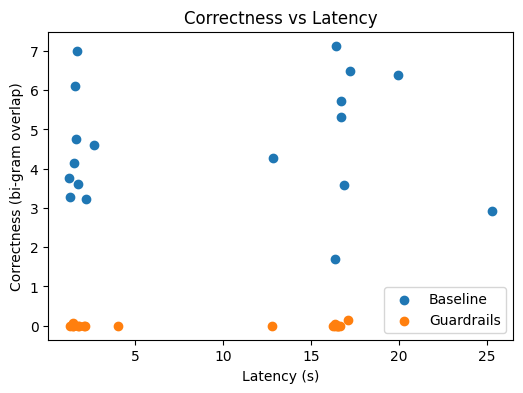

Saved: baseline_results.csv, guardrails_results.csv, ablation_results.csv


In [ ]:
#@title 7) Run baseline vs guardrails; save CSVs + simple plots

baseline_df = run_eval(eval_rows, use_guardrails=False)
guard_df = run_eval(eval_rows, use_guardrails=True)


# baseline_df = run_eval_with_flags(eval_rows, use_guardrails=False)
# guard_df = run_eval_with_flags(eval_rows, use_guardrails=True)


baseline_df.to_csv("baseline_results.csv", index=False)
guard_df.to_csv("guardrails_results.csv", index=False)

summary = pd.DataFrame([
    {
        'variant': 'Baseline',
        'correctness_mean': baseline_df['correctness'].mean(),
        'faithfulness_mean': baseline_df['faithfulness'].mean(),
        'latency_mean_s': baseline_df['latency_s'].mean(),
    },
    {
        'variant': 'With Guardrails',
        'correctness_mean': guard_df['correctness'].mean(),
        'faithfulness_mean': guard_df['faithfulness'].mean(),
        'latency_mean_s': guard_df['latency_s'].mean(),
    },
])
summary.to_csv("ablation_results.csv", index=False)
display(summary)

plt.figure()
plt.scatter(baseline_df['latency_s'], baseline_df['correctness'], label='Baseline')
plt.scatter(guard_df['latency_s'], guard_df['correctness'], label='Guardrails')
plt.xlabel('Latency (s)')
plt.ylabel('Correctness (bi-gram overlap)')
plt.legend()
plt.title('Correctness vs Latency')
plt.show()

print('Saved: baseline_results.csv, guardrails_results.csv, ablation_results.csv')


In [ ]:
#@title 8) Save environment & run config JSONs (reproducibility)
env_info = {
    "python": sys.version,
    "platform": platform.platform(),
    "packages": {}
}
for pkg in ["torch","transformers","sentence-transformers","chromadb","langchain","langchain-community"]:
    try:
        env_info["packages"][pkg] = pkg_resources.get_distribution(pkg).version
    except Exception:
        env_info["packages"][pkg] = None

with open("env_rag_adv.json","w") as f:
    json.dump(env_info, f, indent=2)

run_cfg = {
    "chunk_size": CHUNK_SIZE,
    "chunk_overlap": CHUNK_OVERLAP,
    "bm25_k": K_BM25,
    "dense_k": K_DENSE,
    "top_k_final": TOP_K,
    "embedding_model": "sentence-transformers/all-MiniLM-L6-v2",
    "llm_model": "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    "reranker": RERANKER_MODEL if 'RERANKER_MODEL' in globals() else None,
    "use_reranker": bool(USE_RERANKER) if 'USE_RERANKER' in globals() else False,
}
with open("rag_adv_run_config.json","w") as f:
    json.dump(run_cfg, f, indent=2)

print('Saved env_rag_adv.json & rag_adv_run_config.json')


Saved env_rag_adv.json & rag_adv_run_config.json


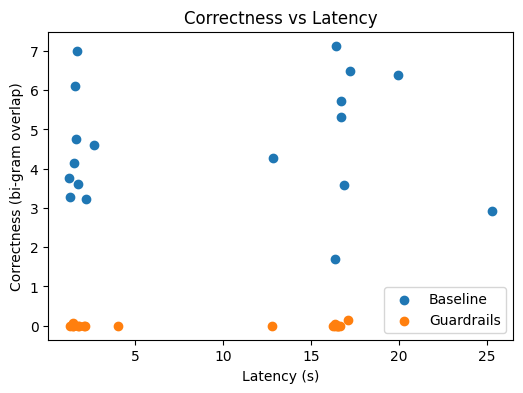

In [ ]:
#@title 9) Saving the graphs

fig, ax = plt.subplots()

ax.scatter(baseline_df['latency_s'], baseline_df['correctness'], label='Baseline')
ax.scatter(guard_df['latency_s'], guard_df['correctness'], label='Guardrails')
ax.set_xlabel('Latency (s)')
ax.set_ylabel('Correctness (bi-gram overlap)')
ax.legend()
ax.set_title('Correctness vs Latency')

# Save using the figure object, not plt
fig.savefig("correctness_vs_latency.pdf", dpi=300, bbox_inches="tight")
fig.savefig("correctness_vs_latency.png", dpi=300, bbox_inches="tight")

plt.show()




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSVs
baseline_df = pd.read_csv("baseline_results.csv")
guardrails_df = pd.read_csv("guardrails_results.csv")
ablation_df = pd.read_csv("ablation_results.csv")

# ---------------------------
# Build Accept/Reject Counts
# ---------------------------
baseline_accept = (baseline_df["correctness"] > 0).sum()
baseline_reject = (baseline_df["correctness"] <= 0).sum()
guardrails_accept = (guardrails_df["correctness"] > 0).sum()
guardrails_reject = (guardrails_df["correctness"] <= 0).sum()

accept_reject_df = pd.DataFrame({
    "Baseline": [baseline_accept, baseline_reject],
    "Guardrails": [guardrails_accept, guardrails_reject]
}, index=["Accepted", "Rejected"])

# ---------------------------
# Plot Accept vs Reject as Bar Chart
# ---------------------------
ax = accept_reject_df.plot(kind="bar", figsize=(6,5))
ax.set_ylabel("Number of Eval Questions")
ax.set_title("Baseline vs Guardrails — Accepted vs Rejected")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("accept_reject_barchart.png", dpi=300)
plt.close()

# ---------------------------
# Save Ablation Table as PNG (larger, readable)
# ---------------------------
def save_wide_table_as_png(df, filename, title=None):
    fig, ax = plt.subplots(figsize=(len(df.columns)*2, 1 + 0.5*len(df)))  # wider fig
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    table = ax.table(
        cellText=df.round(3).values,
        colLabels=df.columns,
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.4, 1.4)  # make cells bigger
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close(fig)

save_wide_table_as_png(ablation_df, "ablation_table.png", title="Ablation Metrics")

print("Saved: accept_reject_barchart.png and ablation_table.png")


Saved: accept_reject_barchart.png and ablation_table.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Build Accept/Reject Counts (same as before)
baseline_accept = (baseline_df["correctness"] > 0).sum()
baseline_reject = (baseline_df["correctness"] <= 0).sum()
guardrails_accept = (guardrails_df["correctness"] > 0).sum()
guardrails_reject = (guardrails_df["correctness"] <= 0).sum()

accept_reject_df = pd.DataFrame({
    "Baseline": [baseline_accept, baseline_reject],
    "Guardrails": [guardrails_accept, guardrails_reject]
}, index=["Accepted", "Rejected"])

# ---------------------------
# Plot Accept vs Reject as Bar Chart (integer y-axis)
# ---------------------------
ax = accept_reject_df.plot(kind="bar", figsize=(6,5))
ax.set_ylabel("Number of Eval Questions")
ax.set_title("Baseline vs Guardrails — Accepted vs Rejected")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # force integer ticks
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("accept_reject_barchart.png", dpi=300)
plt.close()
